**Feststellung:**

Zelle 11:
 - SiLU (114) führt offenbar zu besserer Konvergenz
 - lr = 0.01 i.V.m. bs = 512 (114) ist offenbar nicht zu hoch, auch keine exploding weights (die zu expl. gradients führen könnten)
 - niedrigerer Discount Factor wohl vorübergehend besser, siehe auch Notebook 2103
 - leicht positiver reward offset wirkt sich auch gut auf das Training aus

Letzte Zellen: Es zeigt sich, dass ab ca. 14000 Episoden alle Varianten den Durschschnittswert erlernt haben. Das stärkere Gewichten höherer Abweichugnen durch eine quadratische oder kubische Funktion hat nichts gebracht.

Ein Problem ist wohl, dass die Q-Netzwerke zu wenig lernen. **Diese Q-Funktion müssen deutlich besser konvergieren, sonst schätzen diese die Q-Werte falsch.** Dies ist sicher auch eine Ursache für das Verhalten, dass häufig der Durschschnittssetpoint angenomme wird.

In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess

In [3]:
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [5]:
fig_width = 16

In [6]:
dirnames = ["../checkpoints/s111/20210506-1840/",
            "../checkpoints/s112/20210506-1856/",
            "../checkpoints/s114/20210506-2141/"]

In [7]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [8]:
vh.get_arguments_overview(dirnames)

,s111,s112,s114
lr,0.003,0.003,0.01
discount_factor,0.91,0.91,0.8
batch_size,256,128,512
reward_scale,1.0,0.25,0.5
reward_offset,0.0,0.0,0.1
stp_reward_function,cubic,quadratic,cubic
target_network_update_freq,6,6,9
epsilon_final_step,18100,24000,24000
agent_network,"1HiddenBigLayer,SiLU","2HiddenLayer,Trapezium","1HiddenBigLayer,SiLU"
agent_w_l2,4e-06,2e-06,4e-06


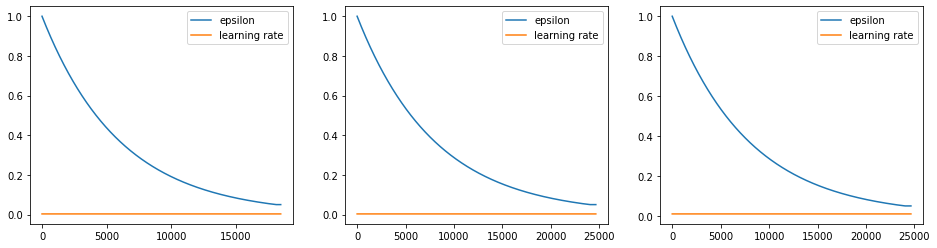

In [9]:
p, _ = vh.complete_plot_epsilon(alldfs, fig_width)
p.show()

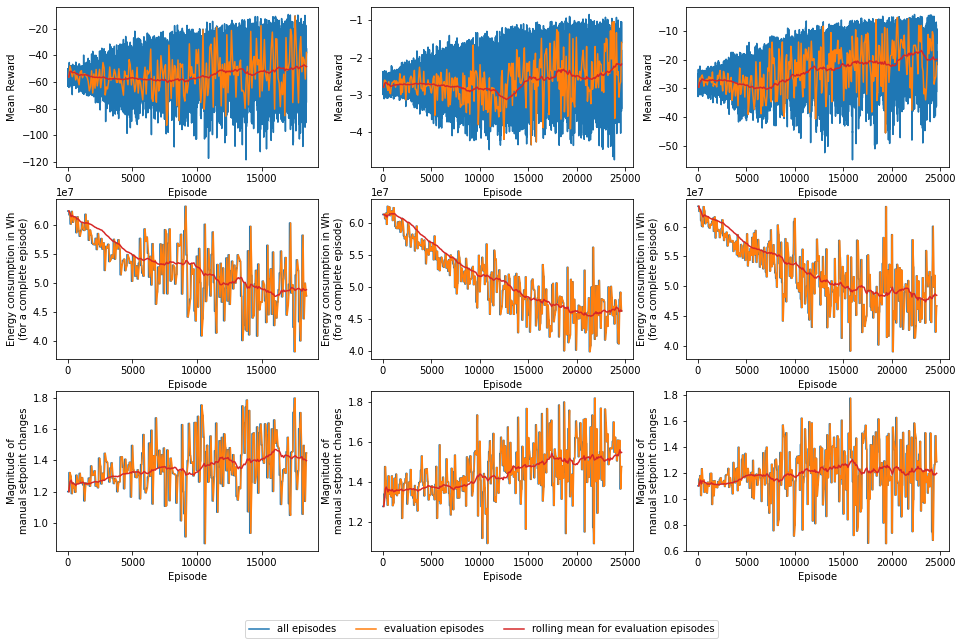

In [10]:
p, _ = vh.complete_plot_reward_stpc_econs(alldfs, fig_width)
p.show()

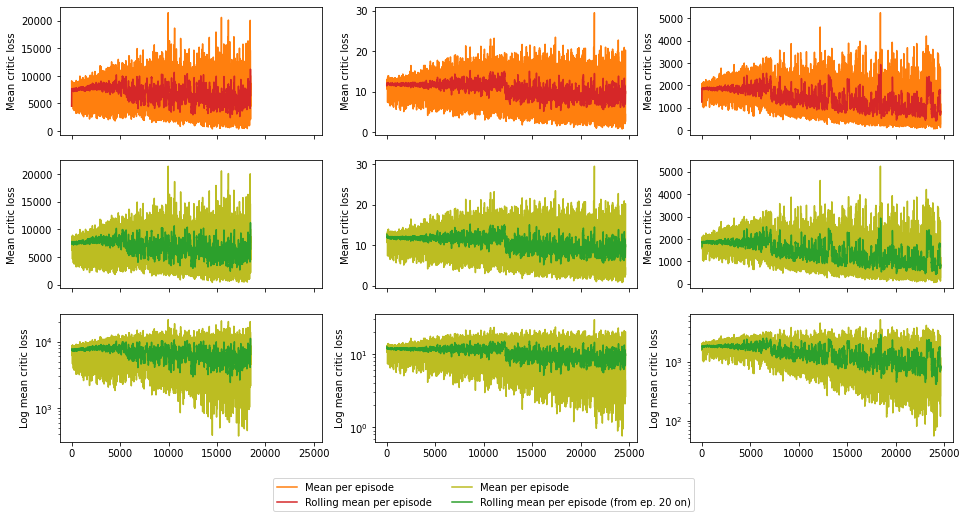

In [11]:
p, _ = vh.complete_plot_losses(alldfs, fig_width, with_agents=False)
p.show()

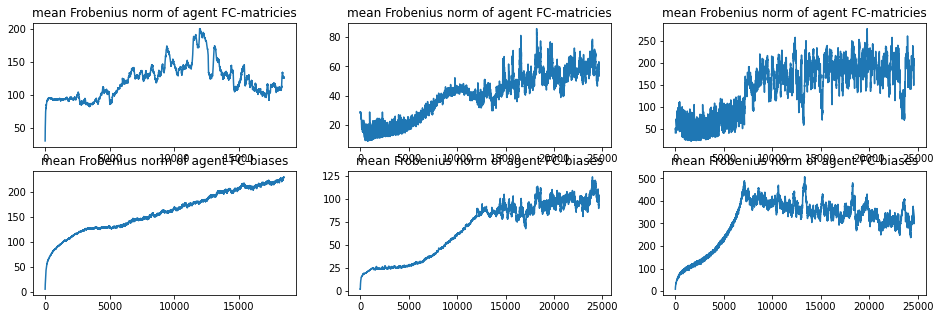

In [12]:
p, _ = vh.complete_plot_frobenius_norms(alldfs, fig_width, with_critics=False)
p.show()

In [13]:
last_available_eval_episodes = vh.compute_last_available_eval_episode(alldfs)

Last available evaluation episode for dfs0:  18479
Last available evaluation episode for dfs1:  24639
Last available evaluation episode for dfs2:  24639


<h3>Details for one week</h3>

In [14]:
#selected_episodes = [1760 - 1, 1760 - 1, 1760 - 1]
#selected_weeks    = [datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1), datetime.datetime(2017, 1, 1)]

In [15]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = vh.select_week_and_episode_for_dfs_list(alldfs, selected_episodes, selected_weeks)

In [16]:
vh.print_reward_informations(subdfs, selected_episodes)

First complete week of evaluation episode
For episode 18479: Energy consumption:   47834.30 kWh; Numer of setpoint changes: 1039.6266101606761
For episode 24639: Energy consumption:   46172.16 kWh; Numer of setpoint changes: 1061.6028126924593
For episode 24639: Energy consumption:   46721.15 kWh; Numer of setpoint changes: 924.0541579242603

Mean values for episode ...
... 18479: Reward: -37.79138 kWh; Setpoint change magnit.:  1.44593; Energy cons.: 66528.93301
... 24639: Reward: -1.58901 kWh; Setpoint change magnit.:  1.47650; Energy cons.: 64217.19326
... 24639: Reward: -20.90348 kWh; Setpoint change magnit.:  1.28519; Energy cons.: 64980.73600


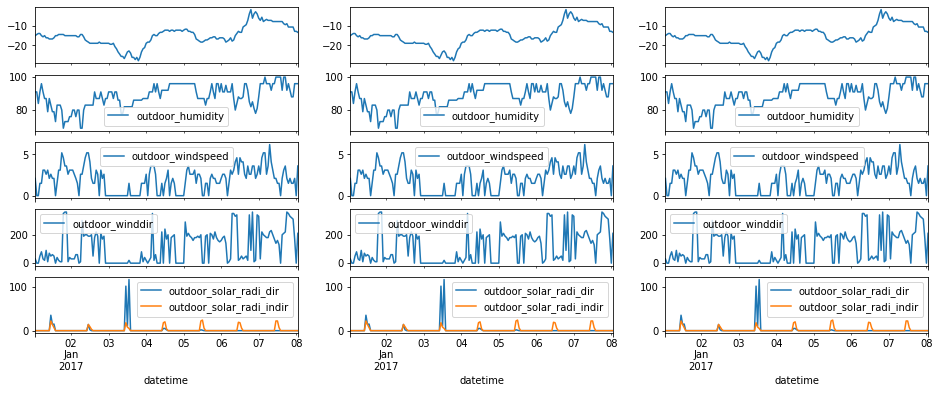

In [17]:
p, _ = vh.complete_plot_weather_information(subdfs, fig_width)
p.show()

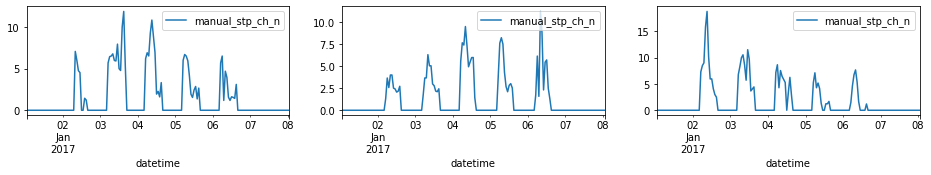

In [18]:
p, _ = vh.complete_plot_number_of_stp_ch(subdfs, fig_width)
p.show()

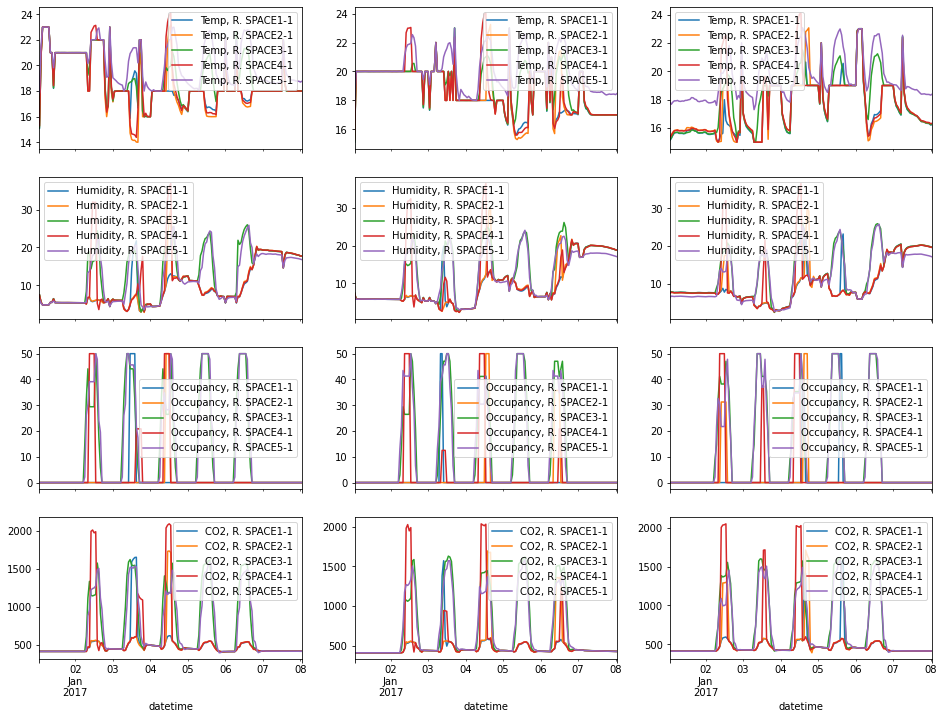

In [19]:
p, _ = vh.complete_plot_room_status(subdfs, fig_width)
p.show()

In [20]:
subdfs_rooms, subdfs_agents = vh.get_available_rooms_and_agents(subdfs)

Available Rooms     in (sub-)dfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs0: [0] 

Available Rooms     in (sub-)dfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs1: [0] 

Available Rooms     in (sub-)dfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in (sub-)dfs2: [0] 



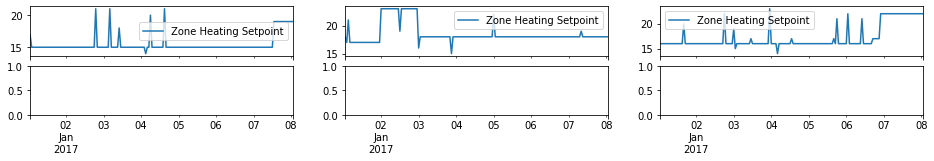

In [21]:
p, _ = vh.complete_plot_all_agent_outputs(subdfs, fig_width, subdfs_agents)
p.show()

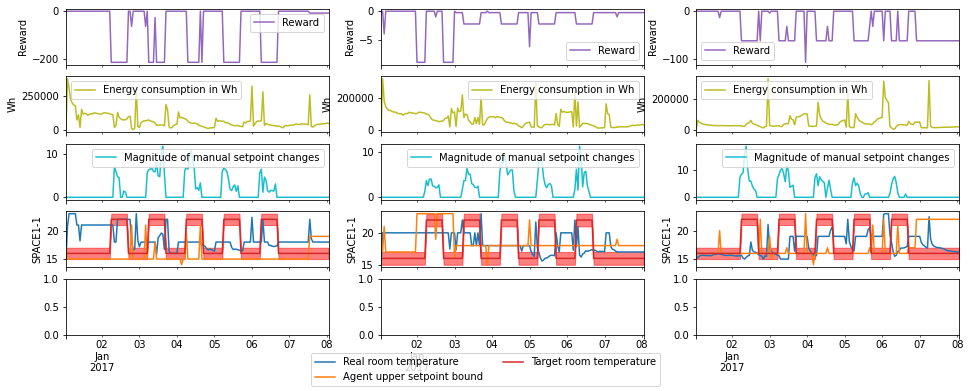

In [22]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a day</h3>

In [23]:
#selected_periods1    = [datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3),
#                        datetime.datetime(2017, 1, 3)]
#selected_periods1_end= [datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4),
#                        datetime.datetime(2017, 1, 4)]

In [24]:
if not "selected_periods1" in locals().keys():
    selected_periods1     = [datetime.datetime(2017, 1, 3) for _ in range(len(alldfs))]
if not "selected_periods1_end" in locals().keys():
    selected_periods1_end = [datetime.datetime(2017, 1, 4) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods1,
            selected_periods1_end)

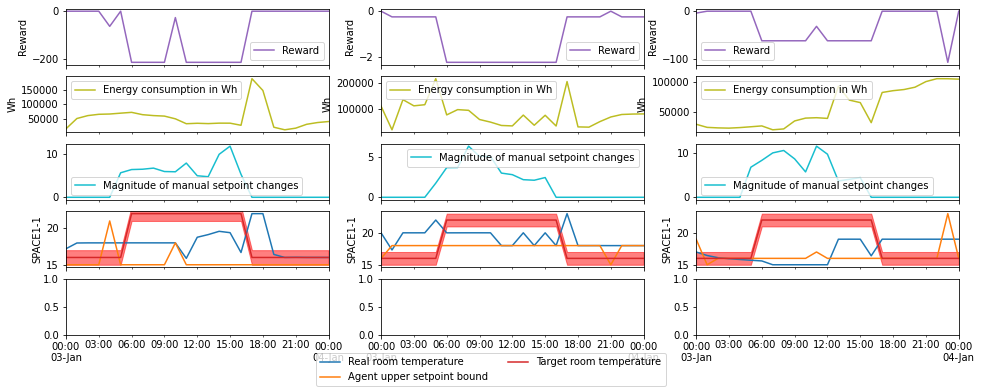

In [25]:
p, _ = vh.complete_plot_total_overview(subdfs, fig_width, subdfs_rooms, subdfs_agents)
p.show()

<h3>Details for a complete month</h3>

In [26]:
#selected_periods2    = [datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1),
#                        datetime.datetime(2017, 1, 1)]

In [27]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            selected_episodes,
            selected_periods2,
            selected_periods2_end)

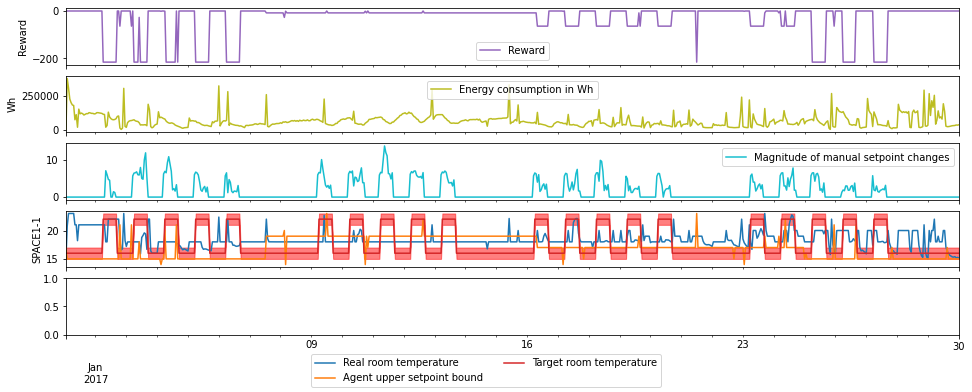

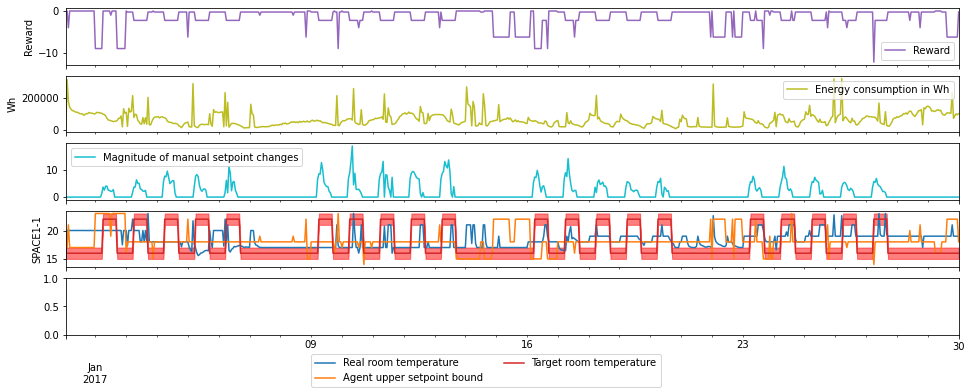

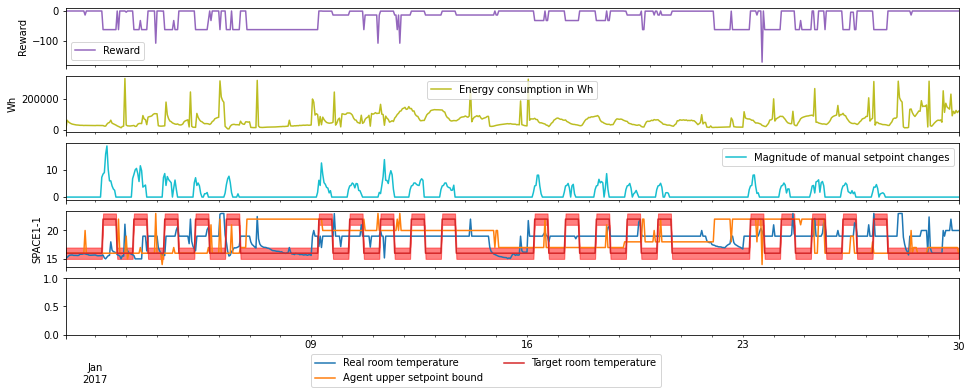

In [28]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

<h3>Additional: Overview over further eval. episodes</h3>

Main question: When does the agent learn to produce more constant outputs?

In [29]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            [3520 - 1, 3520 - 1, 3520 - 1],
            selected_periods2,
            selected_periods2_end)

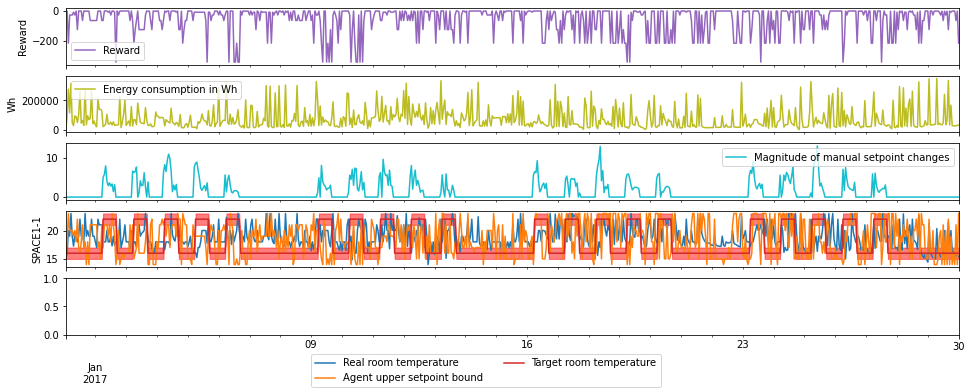

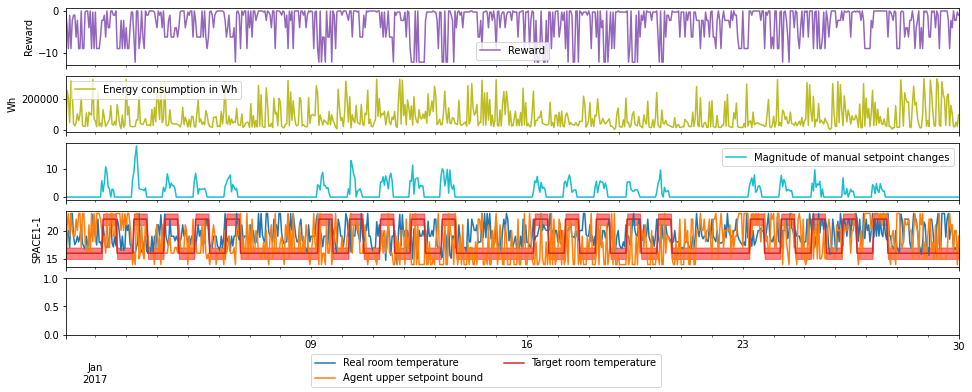

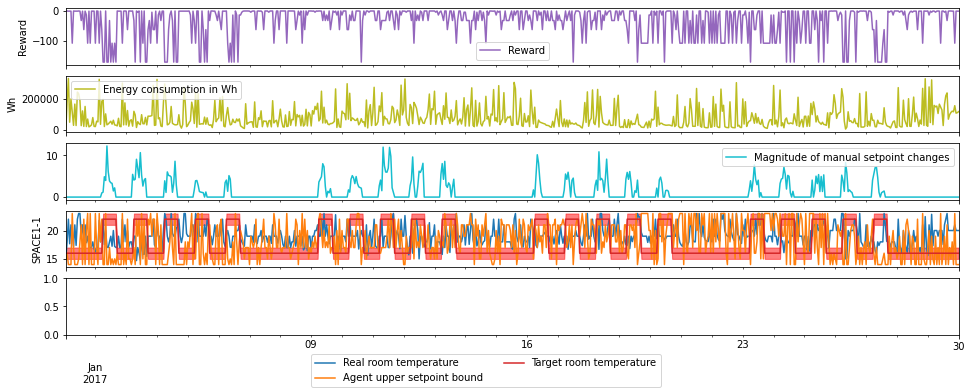

In [30]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

In [31]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            [7920 - 1, 7920 - 1, 7920 - 1],
            selected_periods2,
            selected_periods2_end)

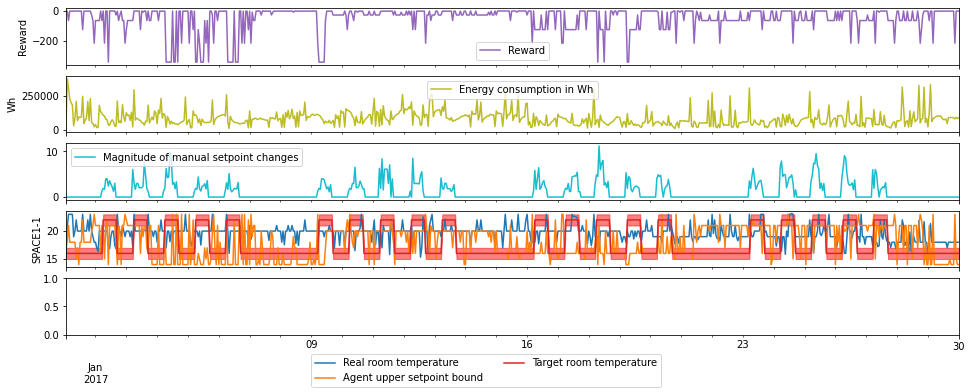

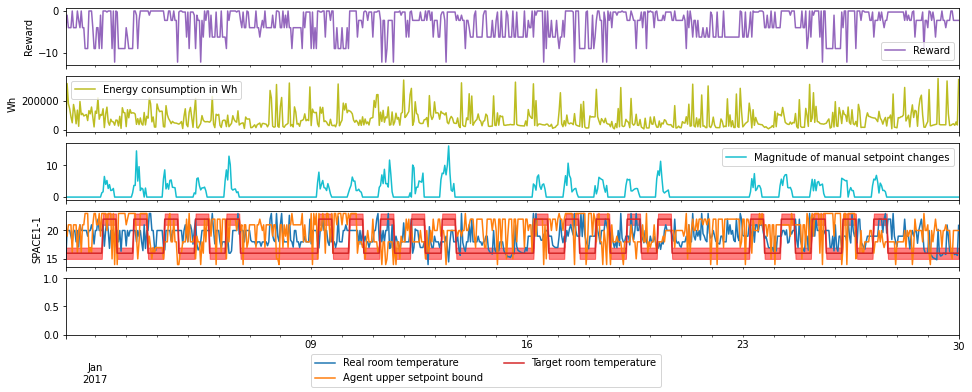

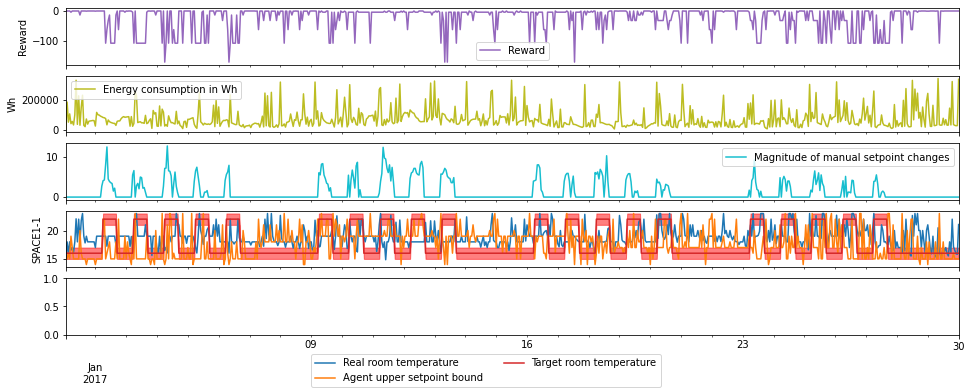

In [32]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

In [33]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            [11440 - 1, 11440 - 1, 11440 - 1],
            selected_periods2,
            selected_periods2_end)

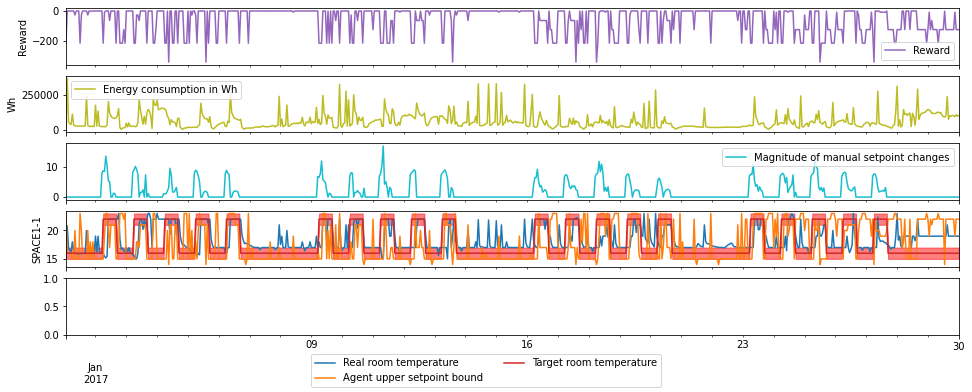

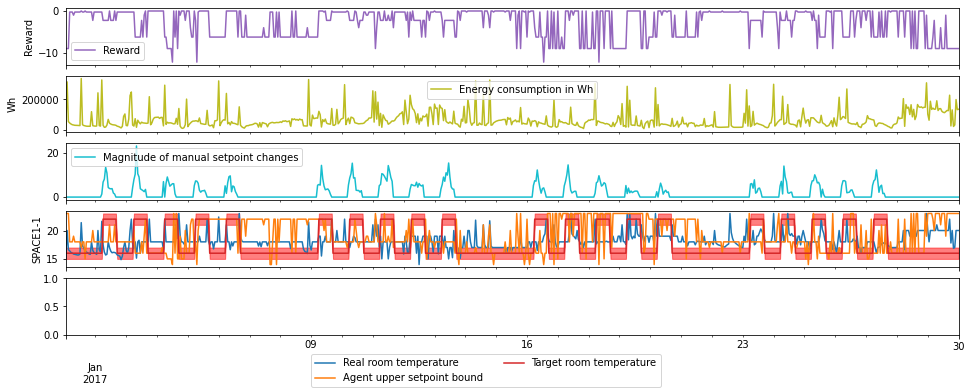

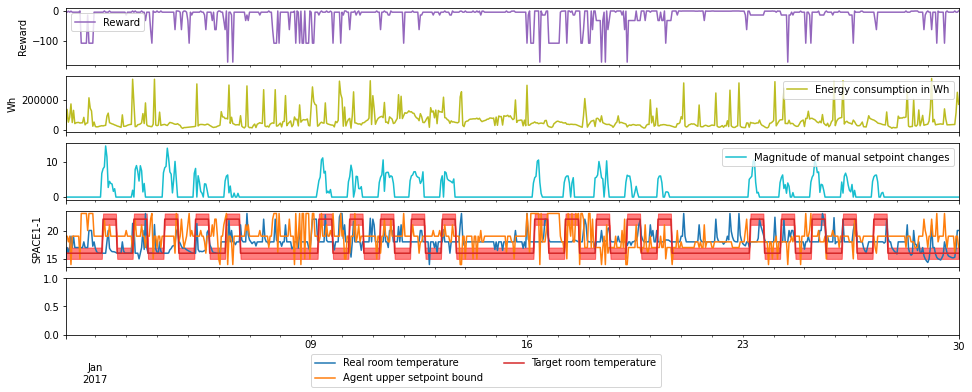

In [34]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()

In [35]:
if not "selected_periods2" in locals().keys():
    selected_periods2     = [datetime.datetime(2017, 1, 1) for _ in range(len(alldfs))]
selected_periods2_end = [datetime.datetime(2017, 1, 30) for _ in range(len(alldfs))]

subdfs = vh.select_week_and_episode_with_end_for_dfs_list(
            alldfs,
            [15840 - 1, 15840 - 1, 15840 - 1],
            selected_periods2,
            selected_periods2_end)

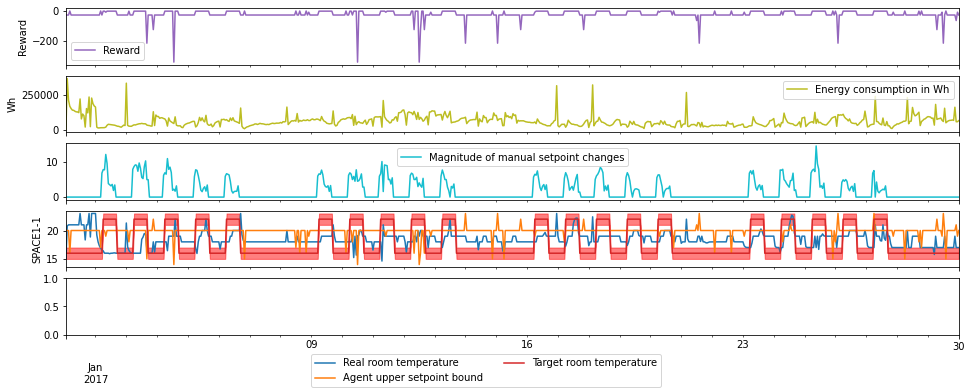

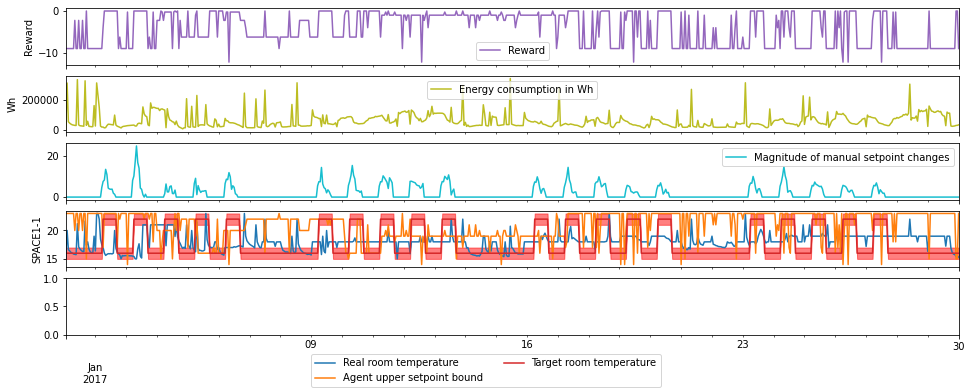

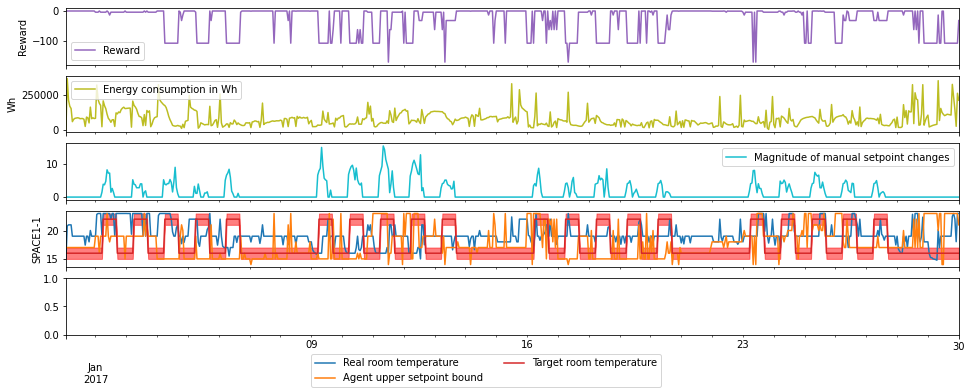

In [36]:
for idx, sdfs in enumerate(subdfs):
    p, _ = vh.complete_plot_total_overview(sdfs, fig_width,
                                           subdfs_rooms[idx],
                                           subdfs_agents[idx])
    p.show()